# Based on Yu et al. 2024

In [1]:
import os

import torch

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import numpy.typing as npt
from typing import Callable

current_device = torch.cuda.current_device()
print(torch.cuda.get_device_name(current_device))

NVIDIA GeForce GTX 960


In [2]:
from nn_helper import MyDataset, get_dataset

train_dataset = MyDataset("data/dataset_train_2.csv")
test_dataset = MyDataset("data/dataset_test_2.csv")

In [ ]:
from nn_models import NNYuEtAl

num_sensors = 6
input_size = num_sensors * 2

#model = MyNN(input_size)
model = NNYuEtAl(input_size)

batch_size = 8

#train_dl, val_dl = get_dataset(train_dataset, 0.2, batch_size)
#x, y = next(iter(train_dl))
#x: torch.Tensor
#print(x.shape) #batch, input_params == 8, 12

#x, y = 
#x = x.to(dtype=torch.float32)
#x = x.unsqueeze(0)
#x = x.reshape(batch_size, 1, input_size)
#x = x.transpose(1, 2)

#print(x.shape)
#y_p = model(x)
#print(y_p.shape)

model.info(batch_size)

Layer (type:depth-idx)                   Output Shape              Param #
NNYuEtAl                                 [8, 2]                    --
├─Conv1d: 1-1                            [8, 20, 10]               80
├─BatchNorm1d: 1-2                       [8, 20, 10]               40
├─MaxPool1d: 1-3                         [8, 20, 5]                --
├─Conv1d: 1-4                            [8, 10, 3]                610
├─BatchNorm1d: 1-5                       [8, 10, 3]                20
├─MaxPool1d: 1-6                         [8, 10, 1]                --
├─Flatten: 1-7                           [8, 10]                   --
├─LSTM: 1-8                              [8, 20]                   2,560
├─LSTM: 1-9                              [8, 20]                   3,360
├─Linear: 1-10                           [8, 2]                    42
Total params: 6,712
Trainable params: 6,712
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.97
Input size (MB): 0.00
Forward/backward p

Loss at epoch 000: train_loss = 1143.925342 / val_loss = 1162.044001
Loss at epoch 010: train_loss = 56.776703 / val_loss = 16.406789
Loss at epoch 020: train_loss = 38.630738 / val_loss = 11.781597
Loss at epoch 030: train_loss = 31.594942 / val_loss = 17.373724
Loss at epoch 040: train_loss = 29.641984 / val_loss = 17.711441
Loss at epoch 050: train_loss = 32.120219 / val_loss = 5.435891
Loss at epoch 060: train_loss = 29.458437 / val_loss = 2.279570
Loss at epoch 070: train_loss = 33.537453 / val_loss = 1.884249
Loss at epoch 080: train_loss = 26.981015 / val_loss = 21.301302
Loss at epoch 090: train_loss = 25.603367 / val_loss = 28.609561
Loss at epoch 100: train_loss = 27.917119 / val_loss = 0.637859
Loss at epoch 110: train_loss = 22.391336 / val_loss = 14.159955
Loss at epoch 120: train_loss = 35.328214 / val_loss = 7.379639
Loss at epoch 130: train_loss = 27.634057 / val_loss = 1.110737
Loss at epoch 140: train_loss = 23.587796 / val_loss = 42.668550
Loss at epoch 150: train_lo

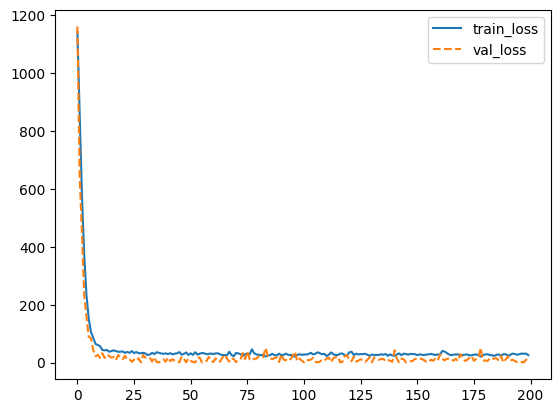

In [ ]:
from nn_train import train_model

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=2e-2)
history = train_model(model, train_dataset, loss_fn, optimizer, current_device, epochs=200, validation_split=0.2, batch_size=batch_size, lambda1=0.02, lambda2=0.01)

# Plot history
plt.figure()

epochs = range(len(history["train_loss"]))
plt_list = [["train_loss", "-"], ["val_loss", "--"]]

for name, style in plt_list:
    plt.plot(epochs, history[name], style, label=name)
plt.legend(loc="best")

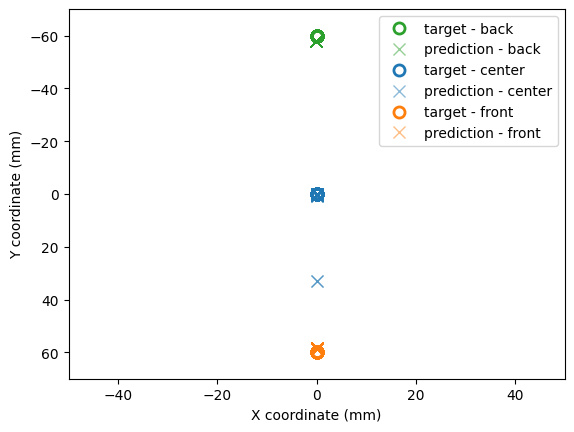

In [ ]:
from nn_helper import LocationsContainer, locations
from torch.utils.data import DataLoader
from torch import Tensor

def test_model(model: torch.nn.Module, dataset: torch.utils.data.Dataset, locations: LocationsContainer, error_fun: Callable[[npt.ArrayLike, npt.ArrayLike], float], device: str = "cpu") -> tuple[plt.Figure, plt.Axes, dict]:
    model.eval()
    model = model.to(device)

    fig, ax = plt.subplots()
    errors = {label: [] for label in locations.get_labels()}

    with torch.no_grad():
        for x, y in DataLoader(dataset, shuffle=True):
            x, y = x.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)
            y_np = y.reshape((2,)).numpy()

            x = x.reshape(x.shape[0], 1, x.shape[1])

            y_predict: Tensor = model(x)
            y_pred_np = y_predict.detach().reshape((2,)).numpy()
            location = locations.from_xy(y_np[0], y_np[1])

            ax.plot(y_np[0], y_np[1], "o", mfc="none", mew=2, markersize=8, color=location.color, label="target - " + location.label)
            ax.plot(y_pred_np[0], y_pred_np[1], "x", markersize=8, color=location.color, label="prediction - " + location.label, alpha=0.5)

            error = error_fun(y_pred_np, y_np)
            errors[location.label].append(error)

            #ax.yaxis.set_inverted(True)
            ax.set_xlim((-50, 50))
            ax.set_ylim((70, -70)) #inverted!

            ax.set_xlabel("X coordinate (mm)")
            ax.set_ylabel("Y coordinate (mm)")

            # force unique labels
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax.legend(by_label.values(), by_label.keys())

    return fig, ax, errors

#model = best_trained_model
def error_fun(prediction: npt.ArrayLike, target: npt.ArrayLike) -> float:
    return np.linalg.norm(target - prediction)

fig, ax, errors = test_model(model, test_dataset, locations, error_fun=error_fun)

Removed 2 values exceeding the threshold of 30


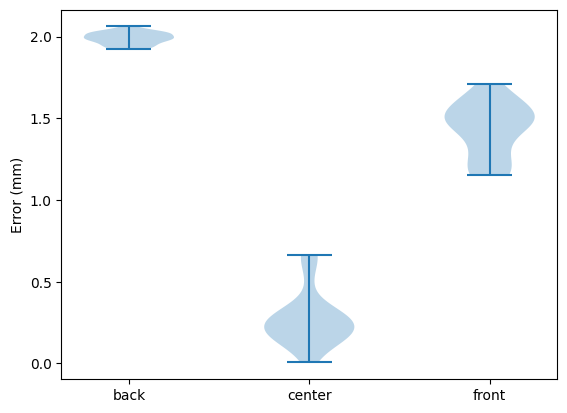

In [20]:
def plot_violins_from_error(errors: dict, threshold: float = 100) -> tuple[plt.Figure, plt.Axes]:
    #ToDo clean up this mess!

    errors = dict(sorted(errors.items())) # sort so that keys are in alphabetical order

    fig, ax = plt.subplots()

    all_data = [v for v in errors.values()]
    removed_count = sum(1 for cat in all_data for val in cat if val > threshold) #check how many values will be removed

    if removed_count > 0:
        print(f"Removed {removed_count} values exceeding the threshold of {threshold}")
        all_data = [[val for val in cat if val <= threshold] for cat in all_data] #hack for quick thresholding
        #actually remove them

    ax.violinplot(all_data)
    ax.set_xticks([i + 1 for i in range(len(all_data))], labels=errors.keys())
    ax.set_ylabel("Error (mm)")

    return fig, ax

fig, ax = plot_violins_from_error(errors, threshold=30)